# Convolutional VAE on Celeb Face Dataset

In this notebook we will go through some experiments using more realistic dataset and we gonna use variational auto-encoder that uses convolutional neural network as encoder/decoder.

### Set GPU for Runtime

<p id="7ecb" class="gy gz ef at ha b hb ja hd jb hf jc hh jd hj je hl" data-selectable-paragraph="">It is so simple to alter default hardware <strong class="ha hm">(CPU to GPU or vice versa)</strong>; just follow <strong class="ha hm">Edit &gt; Notebook settings</strong> or <strong class="ha hm">Runtime&gt;Change runtime type </strong>and <strong class="ha hm">select GPU </strong>as <strong class="ha hm">Hardware accelerator</strong>.</p>

![tittle](https://miro.medium.com/max/740/1*WNovJnpGMOys8Rv7YIsZzA.png)

### Imports

In [1]:
import os
import PIL
from typing import List

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

### Globals

In [2]:
DATA_DIR = 'data'

BATCH_SIZE = 64

IMG_STATS = [0.5]*3, [0.5]*3 # means and standard deviations for normalizing 3 channel RGB images

### Reading Data

We will use CelebA dataset consisting of RGB celebrity face images along with facial characteristic features that we will see below.

The dataset can be downloaded from Kaggle:
https://www.kaggle.com/jessicali9530/celeba-dataset

We will use pre-processed version of the dataset, where pictures have been aligned in center and also excess border has been cropped so that only face occupies the whole image.

In [3]:
if not os.path.exists("data"):
    # Get dataset archive
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/ms-celeb-images-cropped-aligned.zip
    # Unzip directories and files
    !unzip ms-celeb-images-cropped-aligned.zip > /dev/null

In [4]:
# reading image attributes in dataframe

df_attr = pd.read_csv(DATA_DIR + '/list_attr_celeba.csv')
df_attr.shape

(196694, 41)

In [5]:
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
3,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
4,000007.jpg,1,-1,1,1,-1,-1,1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1


Here we will create a custom PyTorch dataset that will load images, crop them to 64x64 and normalize pixel values.

In [6]:
class CelebFaceDataset(torch.utils.data.dataset.Dataset):
    
    def __init__(self, root_dir: str, image_ids: List[str]):
        
        self.root_dir = root_dir
        self.image_ids = image_ids
        
        # original images 
        self.transforms = transforms.Compose([
                                              transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*IMG_STATS)
                                             ]) 
        
    def __getitem__(self, idx: int):
        
        return self.get_by_id(self.image_ids[idx])
    
    def get_by_id(self, image_id: str):
        
        im = PIL.Image.open(os.path.join(self.root_dir, image_id))

        return self.transforms(im)
    
    def __len__(self):
        return len(self.image_ids)

def get_celeba_dls(df: pd.DataFrame):
    
    train_ids, valid_ids = train_test_split(df.image_id.tolist(), test_size=0.01)
    
    print('Train size:', len(train_ids), 'Valid Size:', len(valid_ids))
    
    train_ds = CelebFaceDataset(DATA_DIR + '/celeba', train_ids)
    valid_ds = CelebFaceDataset(DATA_DIR + '/celeba', valid_ids)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=True))

train_dl, valid_dl = get_celeba_dls(df_attr)

Train size: 194727 Valid Size: 1967


In [7]:
# this is a helper class that is used to apply inverse of data normalization so that 
# images return to valid [0, 1] range necessary fot visualization.

class DeNormalize:
    
    def __init__(self, mean, std):
        
        self.mean = mean
        self.std = std

    def __call__(self, x, inplace=False):
        
        tensor = x if inplace else x.clone() 
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        
        return tensor
    
denorm = DeNormalize(*IMG_STATS)

In [8]:
# grabbing single batch and displaying some stats

x = next(iter(train_dl))
x.shape, x.mean(), x.std(), x.min(), x.max()

(torch.Size([64, 3, 64, 64]),
 tensor(0.0131),
 tensor(0.4906),
 tensor(-1.),
 tensor(1.))

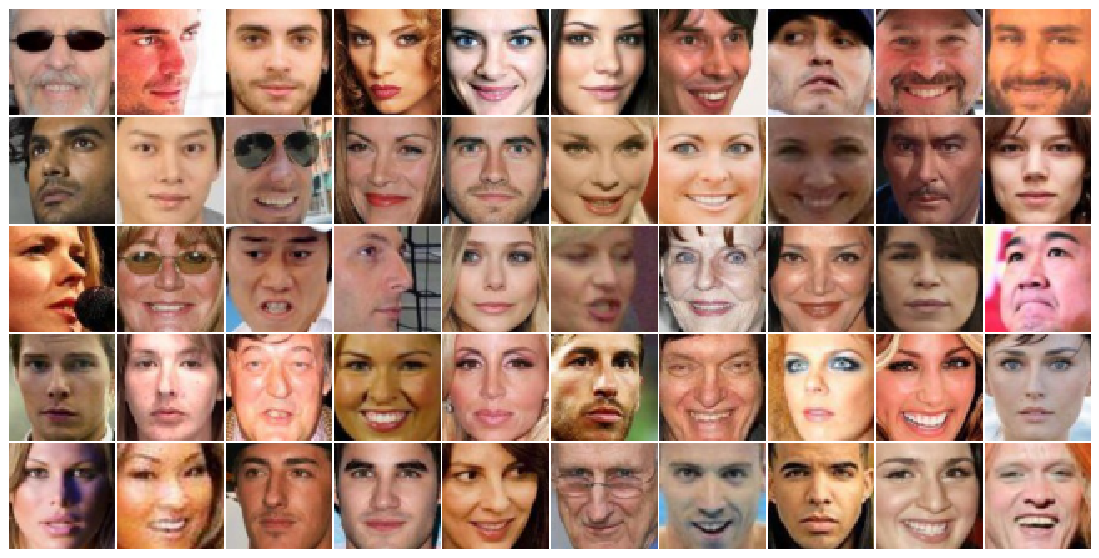

In [9]:
# visualizing bunch of images from our dataset

grid = denorm(make_grid(x[0:50,...], padding=1, pad_value=1, nrow=10).detach()).numpy()
plt.figure(figsize=(20, 10))
plt.imshow(grid.transpose(1, 2, 0))
plt.axis('off');

### Defining Model

In [10]:
# helper function that initializes weights of Convolutional and Linear layers 
# https://arxiv.org/abs/1502.01852

def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None: nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            if m.bias is not None: nn.init.constant_(m.bias, 0)

In [11]:
# function that creates a convolutional block followed by batch normalization and relu activation

def conv(nf: int, of: int, ks: int, stride: int = 1, use_act: bool = True, use_bn: bool = True):
    
    conv = nn.Conv2d(in_channels=nf, 
                     out_channels=of, 
                     kernel_size=ks, 
                     stride=stride, 
                     padding=ks // 2, 
                     bias=not use_bn)
    
    layers = [conv]
    
    if use_bn:
        layers.append(nn.BatchNorm2d(of))
    
    if use_act:
        layers.append(nn.ReLU(inplace=True))
    
    return nn.Sequential(*layers)

conv(3, 64, 3)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channels: int, nf: int):
        super().__init__()
        
        layers = []
        
        layers.append(conv(in_channels, nf, ks=3))
        layers.append(conv(nf, nf, ks=3))
        for i in range(3):
            layers.append(conv(nf, 2*nf, ks=3, stride=2))
            layers.append(conv(2*nf, 2*nf, ks=3, stride=1))
            nf *= 2
        
        self.encoder = nn.Sequential(*layers)
        
        init_weights(self)
        
    def forward(self, x): return self.encoder(x)
    
Encoder(3, 32)

Encoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential

In decoder, we will be using nearest-neighbour upscaling followed by convolutional layer

In [13]:
class Decoder(nn.Module):
    
    def __init__(self, in_channels: int, nf: int):
        super().__init__()
        
        layers = []
        
        for i in range(3):
            layers.append(nn.UpsamplingNearest2d(scale_factor=2))
            layers.append(conv(nf, nf//2, ks=3, stride=1))
            nf //= 2
        
        layers.append(conv(nf, in_channels, ks=1, use_act=False, use_bn=False))
        
        self.decoder = nn.Sequential(*layers)
        
        init_weights(self)
    
    def forward(self, x): return self.decoder(x)
    
Decoder(3, 256)

Decoder(
  (decoder): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (1): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (3): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (5): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (6): Sequential(
      (0): Conv2d(32, 3, kernel_size=(1, 1), st

In [14]:
class ConvolutionalVAE(nn.Module):
    
    def __init__(self, z_dim: int):
        super().__init__()
        
        self.enc_out_shape = (256, 8, 8)
            
        self.encoder = Encoder(3, 32)
        self.decoder = Decoder(3, self.enc_out_shape[0])

        self.mu     = nn.Linear(np.prod(self.enc_out_shape), z_dim)
        self.logvar = nn.Linear(np.prod(self.enc_out_shape), z_dim)
        
        self.fc = nn.Linear(z_dim, np.prod(self.enc_out_shape))
        
        init_weights(self)
        
    def encode(self, x):
        
        enc = self.encoder(x).view(x.shape[0], -1)
        
        mu, logvar = self.mu(enc), self.logvar(enc)
        
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        
        eps = torch.rand_like(mu)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        
        # tanh activation is used to squeeze output pixel values in [-1, 1] range similar to input.
        
        return torch.tanh(self.decoder(self.fc(z).view(-1, *self.enc_out_shape)))
        
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z)

In [15]:
o = ConvolutionalVAE(10)(x)
o.shape, o.mean(), o.std(), o.min(), o.max()

(torch.Size([64, 3, 64, 64]),
 tensor(0.1557, grad_fn=<MeanBackward0>),
 tensor(0.5897, grad_fn=<StdBackward0>),
 tensor(-1.0000, grad_fn=<MinBackward1>),
 tensor(1., grad_fn=<MaxBackward1>))

### Training Loop

Below we build a training loop.  

Instead of L2 term in ELBO loss, we use L1 loss that produces not as blurry outputs as L2 does (recommended by Jeremy Howard from fast.ai). 

We use Adam optimizer with learning learning decay of factor 2 after every epoch.

In [16]:
def elbo_loss(inp, tar, mu, logvar, alpha: float = 1, beta: float = 1):
    
    recon_loss = nn.functional.l1_loss(inp, tar, reduction='none').sum(dim=(1, 2, 3))
            
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = torch.mean(alpha * kld_loss + beta * recon_loss)
    
    return loss, torch.mean(recon_loss), torch.mean(kld_loss)

In [17]:
def show_summary(valid_dl: DataLoader, model: DataLoader):
    
    N_SAMPLES = 15
    
    model.eval()
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, x in enumerate(valid_dl.dataset):
            
            actuals.append(x)
            
            recon_x = model(x.unsqueeze(0).cuda()).cpu()
            
            preds.append(recon_x.squeeze(0))
            
            if i + 1 == N_SAMPLES:
                break
                
    model.train()
            
    grid = denorm(make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES))

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

def train_vae(train_dl: DataLoader, 
              valid_dl: DataLoader,
              model: nn.Module,
              n_epochs: int):
    
    LOG_INTERVAL = 20
    SUMMARY_INTERVAL = 100
    
    model = model.cuda()
    
    model.train()
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    sched = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.5, last_epoch=-1)
    
    acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
    
    i = 1
    for epoch in range(n_epochs):
        for x in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()

            mu, logvar = model.encode(x)
            
            z = model.sample_z(mu, logvar)
        
            x_recon = model.decode(z)
        
            loss, recon_loss, kld_loss = elbo_loss(x_recon, x, mu, logvar, alpha=1, beta=1)

            acc_recon_loss += recon_loss.item()
            acc_kld_loss += kld_loss.item()
            acc_loss += loss.item()
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                
                print('epoch %d | iter %d | loss %.5f | KL loss %.5f | recon loss %.5f' % 
                      (epoch + 1, 
                       i + 1, 
                       acc_loss / LOG_INTERVAL, 
                       acc_kld_loss / LOG_INTERVAL, 
                       acc_recon_loss / LOG_INTERVAL,
                       ))
                
                acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
        sched.step()

In [18]:
# we will use 128 dimensional latent space for this task.

vae = ConvolutionalVAE(128)

As far as it takes a while until network starts producing good quality outputs, we will be using pre-trained weights for visualizations in this notebook.  
  
  
You can still uncomment and run the following cell for few iterations to see how output quality gradually increases as training proceedes. 

In [19]:
# train_vae(train_dl, valid_dl, vae, 50)

In [20]:
# torch.save(vae.state_dict(), 'cnn-vae')

In [21]:
if not os.path.exists('cnn-vae-5-l1.model'):
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/cnn-vae-5-l1.model

In [22]:
# here we load pre-trained VAE for further experiments.

vae.load_state_dict(torch.load('cnn-vae-5-l1.model'))
vae.eval();

## Experiments with Visual Arithmetic in Latent Space

Similar to word2vec, we can do some pretty interesting visual experiments by performing arithmetics in latent space.

For example, we can manipulate certain facial attributes (e.g. wearing sunglasses, having a smile, long hair, etc...) on a picture by simply adding/subtracting the some vectors.

Below we will show how to paint sunglasses and smile on an arbitrary image.

In [23]:
# This function selects 500 images having a certain characteristic (e.g Glasses, Long Hair, etc...) and averages their
# latent vectors in order to get a vector encoding this characteristic.

def get_mean_vec(vae: nn.Module, df: pd.DataFrame, condition):

    vae.cpu()
    
    images = []
    for i, im_id in enumerate(df[condition].image_id.values):
        images.append(valid_dl.dataset.get_by_id(im_id))
        if i >= 250:
            break
        
    images = torch.stack(images)
    
    mu, logvar = vae.encode(images)
        
    return torch.mean(vae.sample_z(mu, logvar), dim=0, keepdim=True)
 
# computing mean vectors of "wearing glasses" and "not wearing glasses"
glasses1 = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == 1))
glasses0 = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == -1))

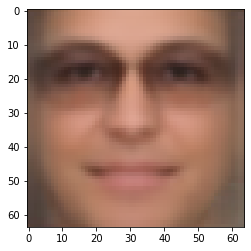

In [24]:
# visualizing average face with glasses

im = denorm(vae.decode(glasses1).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

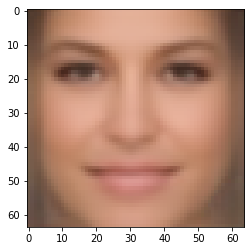

In [25]:
# visualizing average face without glasses

im = denorm(vae.decode(glasses0).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

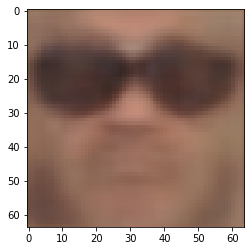

In [26]:
# Visualizing the Vector("wearing glasses") - Vector("not wearing glasses") that gives vector encoding glass information.

im = denorm(vae.decode(glasses1 - glasses0).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

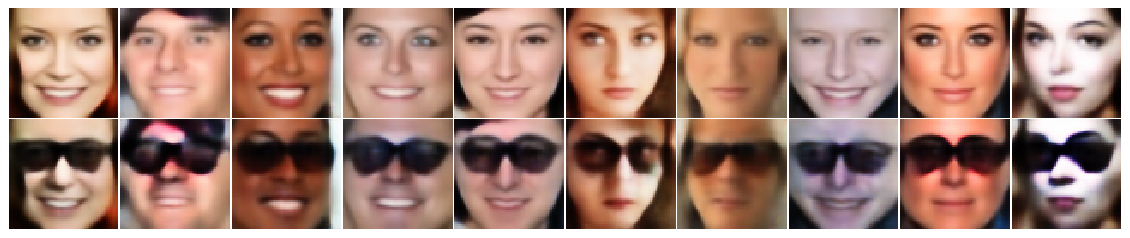

In [27]:
# now we are going to use above computed vectors to generate images with glasses.

images = []
for i, im_id in enumerate(df_attr[df_attr.Eyeglasses == -1].tail(10).image_id.values):
    images.append(valid_dl.dataset.get_by_id(im_id))
images = torch.stack(images)

mu, logvar = vae.encode(images)

z1 = vae.sample_z(mu, logvar)
z2 = vae.sample_z(mu + 2.5*(glasses1 - glasses0), logvar)

images = torch.cat([vae.decode(z1), vae.decode(z2)])

grid = denorm(make_grid(images, padding=1, pad_value=1, nrow=10).detach()).numpy()
plt.figure(figsize=(20, 10))
plt.imshow(grid.transpose(1, 2, 0))
plt.axis('off');

In [28]:
# we can do the same experiment with "smile vector"

smile1 = get_mean_vec(vae, df_attr, (df_attr.Smiling == 1))
smile0 = get_mean_vec(vae, df_attr, (df_attr.Smiling == -1))

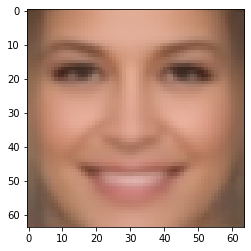

In [29]:
im = denorm(vae.decode(smile1).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

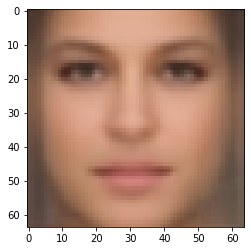

In [30]:
im = denorm(vae.decode(smile0).detach())[0].numpy()
plt.imshow(im.transpose(1,2,0))

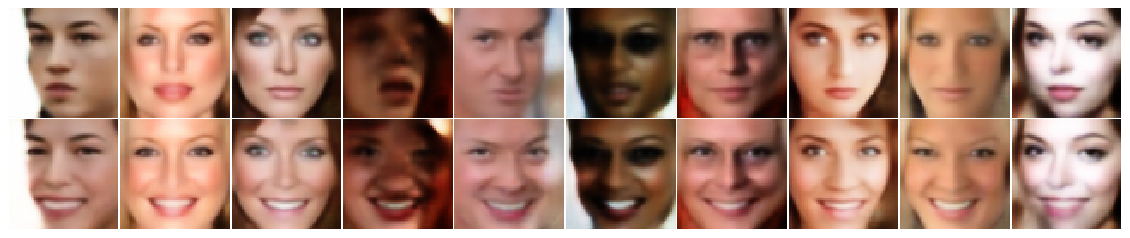

In [31]:
images = []
for i, im_id in enumerate(df_attr[df_attr.Smiling == -1].tail(10).image_id.values):
    images.append(valid_dl.dataset.get_by_id(im_id))
images = torch.stack(images)

mu, logvar = vae.encode(images)

z1 = vae.sample_z(mu, logvar)
z2 = vae.sample_z(mu + 2*(smile1 - smile0), logvar)

images = torch.cat([vae.decode(z1), vae.decode(z2)])

grid = denorm(make_grid(images, padding=1, pad_value=1, nrow=10).detach()).numpy()
plt.figure(figsize=(20, 10))
plt.imshow(grid.transpose(1, 2, 0))
plt.axis('off');

Now we will visualize the 2D manifold where axes encode "Smile" and "Wearing Sunglasses"

In [32]:
# mean Z vector of no smile and with eyeglasses
z_glass_smile = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == 1) & (df_attr.Smiling == -1))

# mean Z vector of smile and with no eyeglasses
z_glass_no_smile = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == -1) & (df_attr.Smiling == 1))

# mean Z vector of no smile and with no eyeglasses
z_no_glass_no_smile = get_mean_vec(vae, df_attr, (df_attr.Eyeglasses == -1) & (df_attr.Smiling == -1))

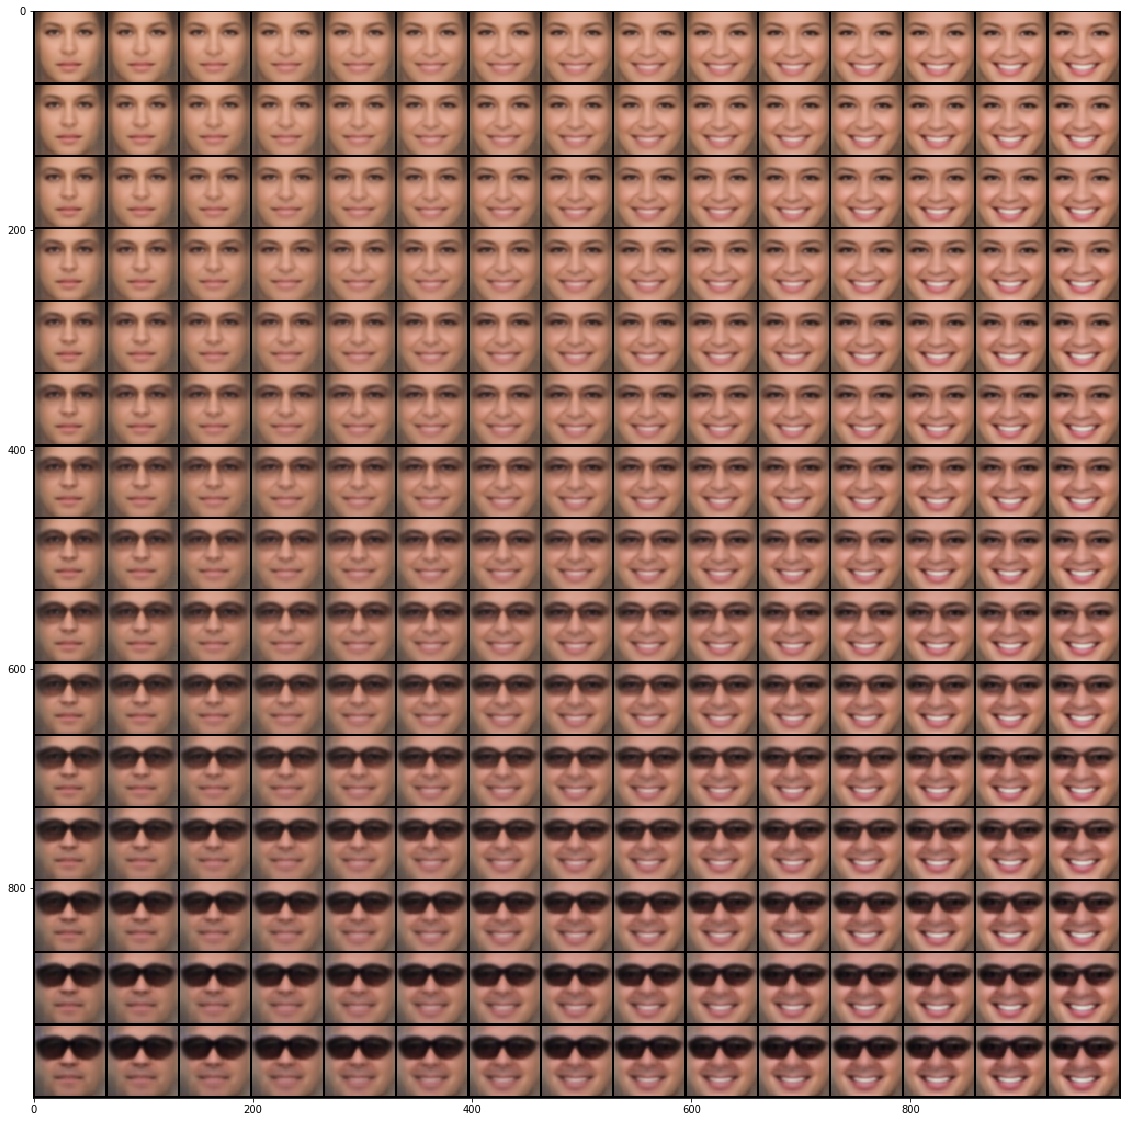

In [33]:
line = np.linspace(0, 2, 15)

# definining 2D basis vectors
I, J = z_glass_smile - z_no_glass_no_smile, z_glass_no_smile - z_no_glass_no_smile

res = []
for a in line:
    for b in line:
        z = z_no_glass_no_smile + a * I + b * J
        x_recon = denorm(vae.decode(z))
        res.append(x_recon)
        
# displaying space

grd = make_grid(torch.cat(res, dim=0), 15).detach().numpy()
plt.figure(figsize=(20, 20))
plt.imshow(grd.transpose(1, 2, 0))